## Preamble



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
import pandas as pd
import numpy as np

## Parse qsub output file



In [1]:
import os, glob

path =r"/home/garrido/Workdir/CMB/analysis/beyondCV/script/ell_50_2000"
all_files = glob.glob(os.path.join(path, "*.o*"))

chi2_theory = []
chi2_begin  = []
chi2_end    = []
success     = []
surveys     = []
start_time  = []
stop_time   = []
seeds       = []

def date2time(line):
    time = line.split(" ", maxsplit=3)[-1]
    time = time[:-5].strip()
    return pd.to_datetime(time, format="%c")

for f in all_files:
    find_begin = False
    success += [False]
    chi2_end += [0]
    with open(f) as stream:
        for line in stream:
            if "DEBUG: seed" in line:
                seeds += [line.split("=")[1].strip()]
            if "DEBUG: survey" in line:
                survey = line.split("=")[1].strip()
                if survey == "SO" or survey == "P":
                  survey += "x" + survey
                surveys += [survey]
            if "chi2(theo)/ndf" in line:
                if survey in line:
                    chi2_theory += [float(line.split("=")[1].strip())]
            if "chi2/ndf" in line:
                if not find_begin:
                    chi2_begin += [float(line.split("=")[1].strip())]
                    find_begin = True
                chi2_end[-1] = float(line.split("=")[1].strip())
            if "Finished succesfully." in line:
                success[-1] = True
            if "Started on" in line:
                start_time += [date2time(line)]
            if "Ended on" in line:
                stop_time += [date2time(line)]
print("INFO: Read {} files".format(len(all_files)))

## Convert =list= into =pandas.DataFrame=



In [1]:
df = pd.DataFrame({"duration": np.array(stop_time)-np.array(start_time),
                   "chi2_theory": chi2_theory,
                   "chi2_begin": chi2_begin,
                   "chi2_end": chi2_end,
                   "success": success,
                   "survey": surveys},
                  index=np.array(seeds, dtype=np.uint))
df.sort_index(inplace=True)
df.head()

# Out[9]:
#+BEGIN_EXAMPLE
  duration  chi2_theory  chi2_begin  chi2_end  success survey
  28 00:28:50     0.972313    3.095984  0.969023    False    PxP
  28 00:16:03     1.005701    3.393066  1.004198     True  SOxSO
  28 00:38:43     0.974076    3.282166  0.972015    False   SOxP
  73 00:27:50     0.960580    2.186273  0.959675    False  SOxSO
  73 00:11:16     0.969954    2.142016  0.969248     True   SOxP
#+END_EXAMPLE

## Get duration statistics



In [1]:
df.duration.describe()

# Out[10]:
#+BEGIN_EXAMPLE
  count                      3003
  mean     0 days 00:20:38.789543
  std      0 days 00:08:35.697947
  min             0 days 00:03:56
  25%             0 days 00:14:32
  50%             0 days 00:19:39
  75%             0 days 00:25:26
  max             0 days 01:47:28
  Name: duration, dtype: object
#+END_EXAMPLE

## Get number of sucessfull minimization



In [1]:
np.sum(df.success)

# Out[11]:
1907

How many minimizations succeed for the three configurations *i.e.* SOxSO, SOxP, PxP



In [1]:
dff = df.groupby(df.index).success.describe()
np.sum((dff.top == True) & (dff.freq == 3)), \
np.sum((dff.top == False) & (dff.freq == 3))

# Out[12]:
(252, 51)

### Plot distribution of $\chi^2$ between successfull and unsuccessful minimizations



In [1]:
import seaborn as sb

# Out[14]:

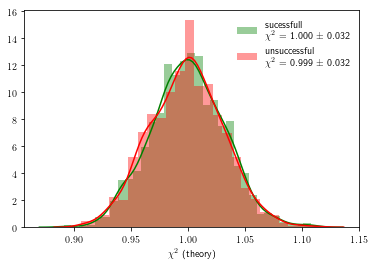

In [1]:
tmpl="{}\n$\chi^2$ = {:.3f} $\pm$ {:.3f}"
df1 = df.chi2_theory[df.success]
df2 = df.chi2_theory[~df.success]
sb.distplot(df1, label=tmpl.format("sucessfull",np.mean(df1),np.std(df1)), color="green", axlabel=r"$\chi^2$ (theory)")
sb.distplot(df2, label=tmpl.format("unsuccessful",np.mean(df2), np.std(df2)), color="red", axlabel=r"$\chi^2$ (theory)")
plt.legend()

# Out[15]:

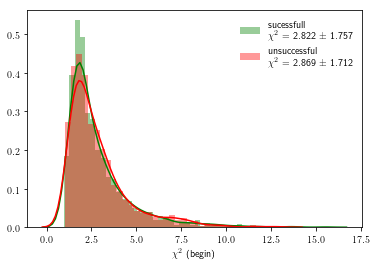

In [1]:
tmpl="{}\n$\chi^2$ = {:.3f} $\pm$ {:.3f}"
df1 = df.chi2_begin[df.success]
df2 = df.chi2_begin[~df.success]
sb.distplot(df1, label=tmpl.format("sucessfull",np.mean(df1),np.std(df1)), color="green", axlabel=r"$\chi^2$ (begin)")
sb.distplot(df2, label=tmpl.format("unsuccessful",np.mean(df2),np.std(df2)), color="red", axlabel=r"$\chi^2$ (begin)")
plt.legend()

# Out[16]:

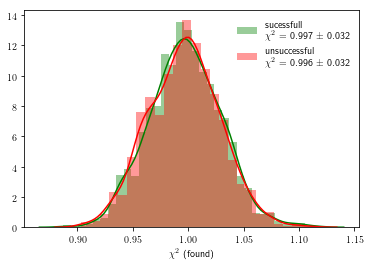

In [1]:
tmpl="{}\n$\chi^2$ = {:.3f} $\pm$ {:.3f}"
df1 = df.chi2_end[df.success]
df2 = df.chi2_end[~df.success]
sb.distplot(df1, label=tmpl.format("sucessfull",np.mean(df1),np.std(df1)), color="green", axlabel=r"$\chi^2$ (found)")
sb.distplot(df2, label=tmpl.format("unsuccessful",np.mean(df2),np.std(df2)), color="red", axlabel=r"$\chi^2$ (found)")
plt.legend()

## Profiles



### ns



In [1]:
import os, glob

path =r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/profile_ns"
all_files = glob.glob(os.path.join(path, "*.pkl"))

import pickle
chi2s = np.empty(len(all_files))
var2profile = np.empty(len(all_files))
success = np.empty(len(all_files))
best = np.empty(len(all_files))

for i,f in enumerate(all_files):
  results = pickle.load(open(f, "rb"))

  # Get minimization configuration
  setup = results.get("setup")
  lmin, lmax = setup.get("experiment").get("lmin"), setup.get("experiment").get("lmax")
  ndf = lmax - lmin - 4

  # Get optimization results
  opt_result = results.get("results").get("OptimizeResult")
  par = results.get("setup").get("cobaya").get("params").get("ns")
  if isinstance(par, float):
    var2profile[i] = par
    best[i] = False
  else:
    var2profile[i] = opt_result.get("x")[2]
    best[i] = True
  chi2s[i] = opt_result.get("fun")/ndf
  success[i] = False if "failed" in opt_result.get("message") else True

Mask for good/bad minization



In [1]:
good = (success == True)
bad  = (success == False)
mini = (best == True)

Group $\chi^2$ by parameter value and find the minimal one



# Out[117]:

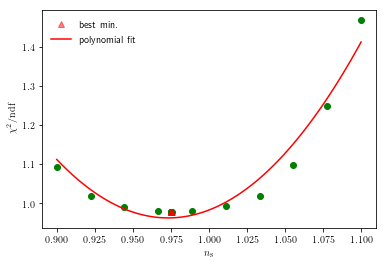

In [1]:
df = pd.DataFrame({"chi2": chi2s, "var": var2profile})
dff = df.groupby("var").min()
plt.plot(dff, "og")
plt.plot(var2profile[mini], chi2s[mini], "^r", alpha=0.5, label="best min.")

# Fit with a 2nd order polynomial
p = np.poly1d(np.polyfit(dff.index, dff.chi2, 2))
x = np.linspace(dff.index[0], dff.index[-1], 100)
plt.plot(x, p(x), "-r", label="polynomial fit")
plt.xlabel(r"$n_\mathrm{s}$")
plt.ylabel(r"$\chi^2/\mathrm{ndf}$")
plt.legend()